In [1]:
import numpy as np
from scipy.linalg import cho_solve, cho_factor
import matplotlib.pyplot as plt
import matplotlib
cmap = 'viridis'

from PIL import Image
color_list = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
marker_list = ['o', 's', 'x', '^']
from inference import *

In [2]:
import pandas as pd
import re

## load and print data labels
filename_label = "./data/IN15/numorsumarytablenew.txt"
with open(filename_label, 'r') as f:
    labels = f.read().splitlines()

# Split the first line as header, the rest as data
header = [col for col in labels[0].split('\t') if col != 'x/y']
# Remove the empty column (the third column, index 2)
data = [ [entry for entry in row.split('\t') if entry != ''] for row in labels[1:] ]

df_labels = pd.DataFrame(data, columns=header)
print(header)
# print(df_labels[df_labels['numor'].astype(str).str.startswith('3')]['numor'])
data_25C = df_labels[df_labels['SampleName'].str.startswith('Dendrimer') & df_labels['numor'].astype(str).str.startswith('3')]
data_10C = df_labels[df_labels['SampleName'].str.startswith('lt_Dendrimer') & df_labels['numor'].astype(str).str.startswith('3')]
data_40C = df_labels[df_labels['SampleName'].str.startswith('ht_Dendrimer') & df_labels['numor'].astype(str).str.startswith('3')]
data_25C.loc[:, 'SampleName'] = data_25C['SampleName'].str.replace(r'^Dendrimer$', 'Dendrimer_25', regex=True)

# Extract temperature, measurement duration, and wavelength from data_25C

def extract_duration(sample_name):
    match = re.search(r'_(\d+)$', sample_name)
    return int(match.group(1)) if match else None

summary = []
for df, label in zip([data_25C, data_10C, data_40C], ['25C', '10C', '40C']):
    temps = df['TempSa'].unique()
    durations = df['SampleName'].apply(extract_duration).unique()
    wavelengths = df['Lambda'].unique()
    angles = df['Angle'].unique()
    summary.append({
        'Label': label,
        'Temperatures': temps,
        'Durations': durations,
        'Wavelengths': wavelengths,
        'Angles': angles
    })

for s in summary:
    print(f"{s['Label']}:")
    print(f"  Temperatures: {s['Temperatures']}")
    print(f"  Durations: {s['Durations']}")
    print(f"  Wavelengths: {s['Wavelengths']}")
    print(f"  Angles: {s['Angles']}\n")


['SampleName', 'TuneWave', 'numor', 'Average', 'averErr', 'Pol', 'PolErr', 'Echo_khi', 'phmap_stddev', 'phmap_khi', 'MonRate', 'TempSa', 'TempSaErr', 'TempRg', 'TempRgErr', 'Selector', 'Lambda', 'Angle']
25C:
  Temperatures: ['24.99995' '25' '25.00005' '25.000099' '25.000248' '25.000198'
 '24.999901' '24.999851' '24.999802']
  Durations: [25  5 10 50]
  Wavelengths: ['12' '10' '8' '6']
  Angles: ['3.49' '5.51' '7.01' '11.49']

10C:
  Temperatures: ['10.00005' '12.600346' '9.999703' '10.000099' '10.002921' '10.000545'
 '10.001683' '9.9984158' '10.000644' '10.001782' '10.000495' '10.001436'
 '9.9996535' '9.999802' '10.000198' '10.000149']
  Durations: [25  5 10 50]
  Wavelengths: ['10' '12' '6' '8']
  Angles: ['5.51' '3.49' '11.49' '7.01']

40C:
  Temperatures: ['40.000247' '39.996535' '39.999852' '40' '39.999951' '39.999208'
 '39.999753' '39.999406' '40.000049' '40.000198' '39.999752' '40.000099']
  Durations: [ 5 10 25 50]
  Wavelengths: ['10' '12' '6' '8']
  Angles: ['5.51' '3.49' '11

In [3]:
duration_list = np.unique([extract_duration(name) for name in data_25C['SampleName']])
conf_list, conf_indices = np.unique(data_25C['Lambda'], return_index=True)
# Sort angle_list according to conf_indices
angle_list_sorted = data_25C['Angle'].iloc[conf_indices].values
print("Wavelength for each configurations:", conf_list)
print("Angles for each configurations:", angle_list_sorted)
# Calculate Q for each configuration using Lambda and Angle
# Q = (4 * pi / lambda) * sin(theta / 2)
# Lambda in Angstrom, Angle in degrees
def calc_Q(lambda_A, angle_deg):
    theta_rad = np.deg2rad(angle_deg)
    return (4 * np.pi / lambda_A) * np.sin(theta_rad / 2)
Qm_list = []
for lam, ang in zip(conf_list.astype(float), angle_list_sorted.astype(float)):
    Q = calc_Q(lam, ang)
    Qm_list.append(Q)
Qm_list = np.array(Qm_list)
print("Q values for each configuration:", np.round(Qm_list, 4))

rebin_list = [3, 6, 9]

Wavelength for each configurations: ['10' '12' '6' '8']
Angles for each configurations: ['5.51' '3.49' '11.49' '7.01']
Q values for each configuration: [0.0604 0.0319 0.2097 0.096 ]


## 25C

In [4]:
data = data_40C.copy()
path = "./data/IN15/T40/"
rebin = rebin_list[2]

/tmp/ipykernel_313356/1150145198.py:70: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(Qt_grid[0]).reshape([-1,1])
/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/mpl_toolkits/mplot3d/proj3d.py:124: RuntimeWarning: invalid value encountered in divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


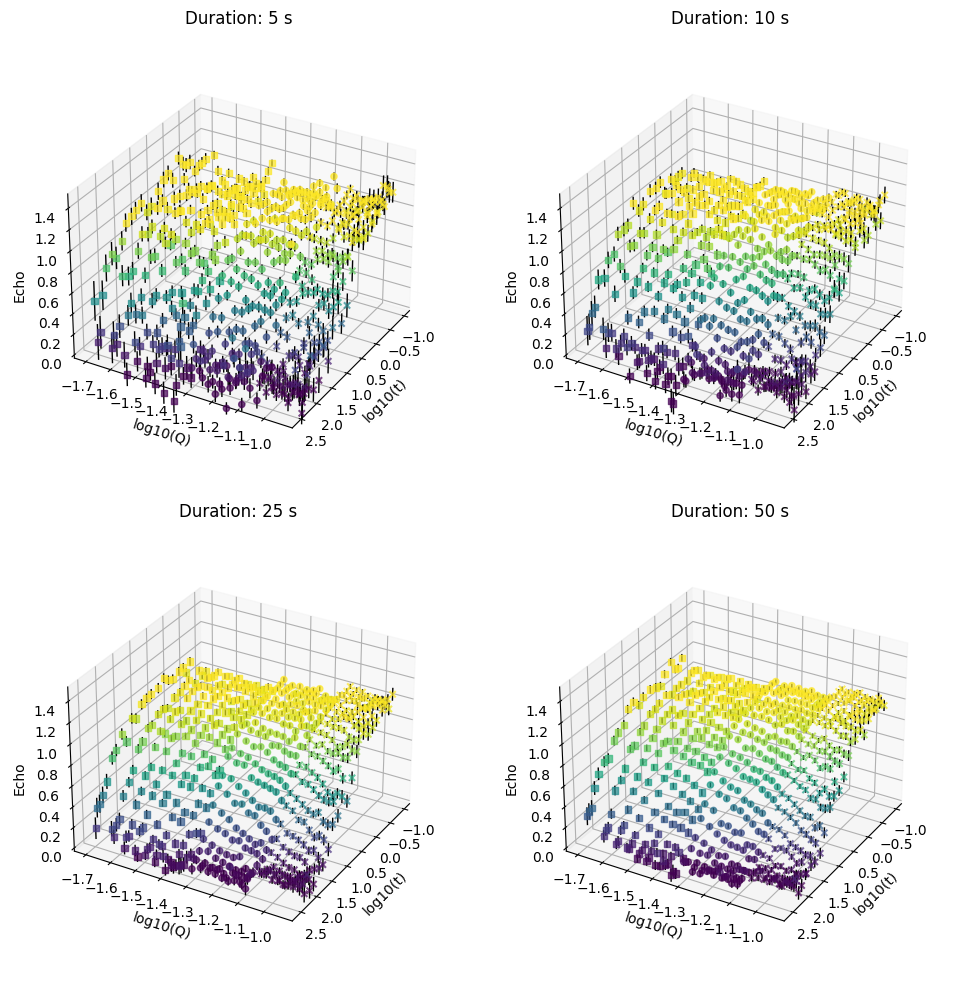

In [5]:
fig = plt.figure(figsize=(10, 10))
axs = []

sqt_list = []
sqt_err_list = []
I_0_list = []
I_0_err_list = []
for i, duration in enumerate(duration_list):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    axs.append(ax)
    Q_list = []
    echo_list = []
    echo_err_list = []
    t_list = []
    Qt_grid_list = []
    Q_flattened_list = []
    t_flattened_list = []
    echo_flattened_list = []
    echo_err_flattened_list = []
    average_list = []
    average_err_list = []
    for i_conf, conf in enumerate(conf_list[[0, 1, 3]]):  # Only use the first four configurations
        # Find the row in data_25C matching duration and Lambda (conf)
        row = data[(data['SampleName'].str.endswith(f'_{duration}')) & (data['Lambda'] == str(conf))]
        numor = row.iloc[0]['numor']
        # print(f"Processing numor: {numor}, conf: {conf}, duration: {duration}")
        filename_e = path+f"sl{rebin}/MD_e_{numor}.txt"
        filename_AP = path+f"sl{rebin}/MD_AP_{numor}.txt"

        # Load the data from filename_AP and extract the Q values and other columns
        data_AP = np.loadtxt(filename_AP, skiprows=2)
        Q = data_AP[:, 0]
        average = data_AP[:, 1]
        averErr = data_AP[:, 2]
        pol = data_AP[:, 3]
        polErr = data_AP[:, 4]

        Q_list.append(Q)
        average_list.append(average)
        average_err_list.append(averErr)
        
        # load the data from filename_e and extract the echo values
        data_e = np.loadtxt(filename_e, skiprows=2)
        t = data_e[:, 0]
        # Extract the echo columns corresponding to each Q
        echo_cols = np.array([i*2+1 for i in range(len(Q))])
        echo_values = data_e[:, echo_cols]
        echo_err = data_e[:, echo_cols+1]
        echo_flattened = echo_values.flatten()
        echo_err_flattened = echo_err.flatten()

        echo_list.append(echo_values)
        echo_err_list.append(echo_err)
        t_list.append(t)
        
        Qt_grid = np.meshgrid(t, Q, indexing='ij')
        Qt_grid_list.append(Qt_grid)
        Q_flattened = Qt_grid[1].flatten()
        t_flattened = Qt_grid[0].flatten()
        
        Q_flattened_list.append(Q_flattened)
        t_flattened_list.append(t_flattened)
        echo_flattened_list.append(echo_flattened)
        echo_err_flattened_list.append(echo_err_flattened)
        
        # Scatter plot with error bars
        multiplier = 1.0
        # if conf == 3:
        #     multiplier = 0.5
        x = np.log10(Qt_grid[0]).reshape([-1,1])
        y = np.log10(Qt_grid[1]).reshape([-1,1])
        z = echo_values.reshape([-1,1])*multiplier
        zerr = echo_err.reshape([-1,1])*multiplier
        ax.scatter(x, y, z, c=z, cmap=cmap, alpha=0.7, vmax=1, vmin=0, marker=marker_list[i_conf])
        # ax.scatter(np.log10(Qt_grid[0]), np.log10(Qt_grid[1]), echo_values*multiplier, marker=marker_list[i_conf])
        
        # Add vertical error bars
        for xi, yi, zi, ezi in zip(x.ravel(), y.ravel(), z.ravel(), zerr.ravel()):
            ax.plot([xi, xi], [yi, yi], [zi - ezi, zi + ezi], color='k', alpha=1, linewidth=1)


        ax.view_init(elev=30, azim=30)
        ax.set_zlim(0, 1.5)
        ax.set_xlabel('log10(t)')
        ax.set_ylabel('log10(Q)')
        ax.set_zlabel('Echo', rotation=90)
        ax.set_box_aspect(None, zoom=0.85)
        ax.set_title(f'Duration: {duration} s')
        
    # Concatenate echo_flattened_list for this duration and append to sqt_list
    sqt_list.append(np.concatenate(echo_flattened_list))
    sqt_err_list.append(np.concatenate(echo_err_flattened_list))
    # Concatenate Q_flattened_list and t_flattened_list for this duration
    Q_flattened = np.concatenate(Q_flattened_list)
    t_flattened = np.concatenate(t_flattened_list)
    I_0_list.append(np.concatenate(average_list, axis=0))
    I_0_err_list.append(np.concatenate(average_err_list, axis=0))
    
    
plt.tight_layout(pad=1.0)

In [6]:
I_0_list

[array([0.50955, 0.49676, 0.52787, 0.51573, 0.50131, 0.48251, 0.40692,
        0.36742, 0.28686, 0.26288, 0.27161, 0.28055, 0.3032 , 0.31713,
        0.30698, 0.27666, 0.25469, 0.21615, 0.5743 , 0.54564, 0.53235,
        0.46949, 0.43636, 0.38923, 0.29719, 0.24815, 0.17057]),
 array([0.5063 , 0.49509, 0.53304, 0.52166, 0.5009 , 0.48356, 0.40964,
        0.36924, 0.2857 , 0.264  , 0.27496, 0.28381, 0.30137, 0.31512,
        0.30315, 0.27248, 0.25773, 0.21966, 0.57456, 0.54459, 0.53559,
        0.46989, 0.43547, 0.39338, 0.29568, 0.25159, 0.17242]),
 array([0.4977 , 0.48456, 0.52239, 0.51045, 0.49403, 0.47521, 0.40146,
        0.36262, 0.28237, 0.26012, 0.27126, 0.2798 , 0.29606, 0.31428,
        0.30367, 0.26975, 0.25262, 0.21741, 0.57141, 0.53597, 0.53032,
        0.46372, 0.42846, 0.38299, 0.29211, 0.24685, 0.17017]),
 array([0.49781, 0.48486, 0.52105, 0.50982, 0.49312, 0.474  , 0.40311,
        0.36344, 0.28477, 0.25841, 0.26793, 0.27643, 0.29248, 0.31163,
        0.30195, 0.26809, 0

L: 681, M: 1221, N: 15
Prior scaling alpha: 0.0008012 (match_stat=mean)


/tmp/ipykernel_313356/3292686443.py:60: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(np.log10(t_obs), np.log10(Q_obs), sqt_GPR_obs, c=sqt_GPR_obs, alpha=0.7, vmax=1, vmin=0)


L: 681, M: 1221, N: 15
Prior scaling alpha: 0.0004597 (match_stat=mean)
L: 681, M: 1221, N: 15
Prior scaling alpha: 0.0002262 (match_stat=mean)
L: 681, M: 1221, N: 15
Prior scaling alpha: 0.0001405 (match_stat=mean)


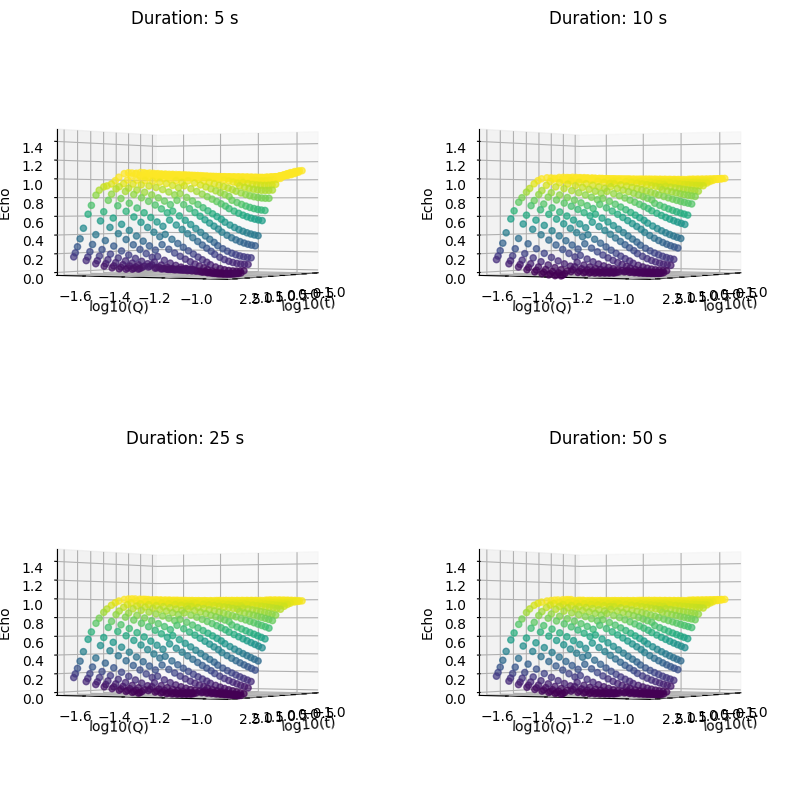

In [20]:
from scipy.optimize import curve_fit
fig = plt.figure(figsize=(10, 10))
sqt_GPR_list = []
sqt_GPR_err_list = []
A_GPR_list = []
for i, duration in enumerate(duration_list):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    axs.append(ax)
    sqt_exp = sqt_list[i]
    sqt_exp_lt = sqt_list[3]  # Take every third element
    delta_sqt_exp = sqt_err_list[i]
    Q_obs = Q_flattened
    t_obs = t_flattened

    # append the observed data with known BCs
    Q_unique = np.unique(Q_obs)
    Q_app_grid, t_app_grid = np.meshgrid(np.logspace(np.log10(Q_obs.min()), np.log10(Q_obs.max()), 30), np.logspace(1, 2, 20))
    t_zero = np.exp(-np.logspace(0, np.log10(Q_obs.max())-np.log10(Q_obs.min()), 30))*1e4
    t_app_grid = t_app_grid * t_zero
    Q_app = Q_app_grid.flatten()
    t_app = t_app_grid.flatten()
    sqt_exp_app = np.zeros_like(Q_app)
    epsilon_app = 1e-3
    delta_sqt_exp_app = np.ones_like(t_app) * epsilon_app
    Q_obs_app = np.concatenate([Q_obs, Q_app])
    t_obs_app = np.concatenate([t_obs, t_app])
    sqt_exp_app = np.concatenate([sqt_exp, sqt_exp_app])
    delta_sqt_exp_app = np.concatenate([delta_sqt_exp, delta_sqt_exp_app])

    Q_eval_grid, t_eval_grid = np.meshgrid(np.logspace(np.log10(Q_obs.min()), np.log10(Q_obs.max()), 30), np.logspace(-1.5, 2.5, 2))
    Q_eval = Q_eval_grid.flatten()
    t_eval = t_eval_grid.flatten()
    Q_eval = np.concatenate([Q_obs, Q_eval])
    t_eval = np.concatenate([t_obs, t_eval])

    lambda_ = 0.24
    mu_ = lambda_/2

    N_Prony = 15
    # using a nonlinear spacing (quadratic in log-space)
    log_tau = np.linspace(0.5, 2.5, N_Prony)
    log_tau_dense = 0.5 + (2.5 - 0.5) * (np.linspace(0, 1, N_Prony) ** 2)
    list_tau_i = 10 ** log_tau_dense
    # list_tau_i = np.linspace(0.05, 500, N_Prony)
    tau = np.array(list_tau_i)
    bg_mode = False

    # A_GPR, K_GPR, sqt_GPR = bayesian_inference(
    #     sqt_exp, delta_sqt_exp, np.log(Q_obs), t_obs, np.log(Q_eval), t_eval, tau, mu_, lambda_, bg_mode=bg_mode, sigma_scale = 1, prior_mean_scale=10.0
    # )
    
    A_GPR, K_GPR, sqt_GPR, alpha = bayesian_inference_scale(
        sqt_exp_app, delta_sqt_exp_app, np.log(Q_obs_app), t_obs_app, np.log(Q_eval), t_eval, tau, mu_, lambda_, bg_mode=bg_mode, sigma_scale = 1, prior_mean_scale=0.0, use_diffusivity_prior=False
    )

    sqt_GPR_obs = sqt_GPR[:len(sqt_exp)]
    sqt_GPR_list.append(sqt_GPR_obs)
    A_GPR_list.append(A_GPR)

    ax.scatter(np.log10(t_obs), np.log10(Q_obs), sqt_GPR_obs, c=sqt_GPR_obs, alpha=0.7, vmax=1, vmin=0)
    # ax.scatter(np.log10(t_obs), np.log10(Q_obs), sqt_GPR-sqt_exp_lt, c=sqt_GPR-sqt_exp_lt, alpha=0.7, vmax=0.5, vmin=-0.5, cmap="bwr")

    ax.view_init(elev=0, azim=30)
    ax.set_zlim(0, 1.5)
    ax.set_xlabel('log10(t)')
    ax.set_ylabel('log10(Q)')
    ax.set_zlabel('Echo', rotation=90)
    ax.set_box_aspect(None, zoom=0.85)
    ax.set_title(f'Duration: {duration} s')

/tmp/ipykernel_313356/3291304979.py:13: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(np.log10(t_obs), np.log10(Q_obs), sqt_GPR-sqt_exp_lt, c=sqt_GPR-sqt_exp_lt, alpha=1, vmax=0.5, vmin=-0.5, cmap="bwr")


0.06109142516539611
0.03924070680788898
0.032653584600616556
0.03283587160821324


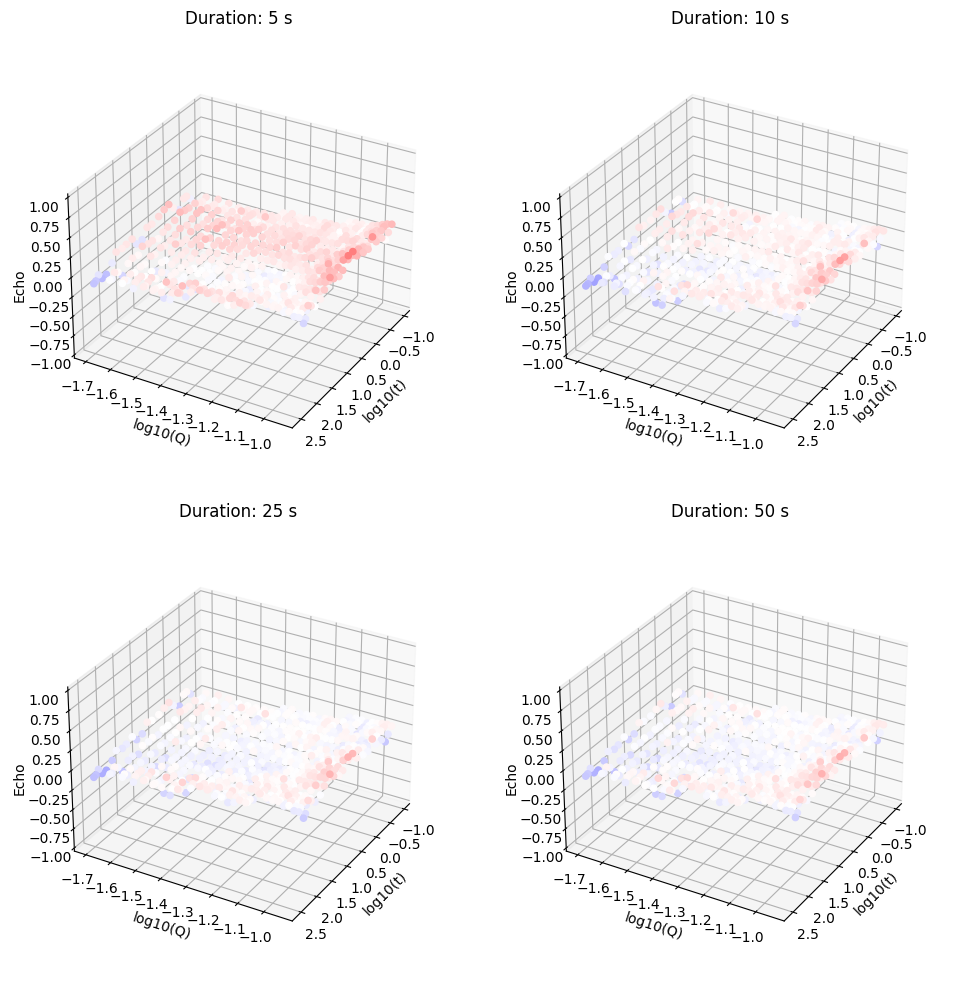

In [21]:
from scipy.optimize import curve_fit
fig = plt.figure(figsize=(10, 10))
for i, duration in enumerate(duration_list):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    axs.append(ax)
    
    sqt_GPR = sqt_GPR_list[i]
    sqt_exp = sqt_list[i]
    sqt_exp_err = sqt_err_list[i]
    # sqt_exp_err_lt 

    
    ax.scatter(np.log10(t_obs), np.log10(Q_obs), sqt_GPR-sqt_exp_lt, c=sqt_GPR-sqt_exp_lt, alpha=1, vmax=0.5, vmin=-0.5, cmap="bwr")
    # ax.scatter(np.log10(t_obs), np.log10(Q_obs), sqt_exp-sqt_exp_lt, c='k', alpha=0.7, vmax=0.5, vmin=-0.5, cmap="bwr")
    
    print(np.sqrt(np.mean(((sqt_GPR-sqt_exp_lt))**2)))

    ax.view_init(elev=30, azim=30)
    ax.set_zlim(-1, 1)
    ax.set_xlabel('log10(t)')
    ax.set_ylabel('log10(Q)')
    ax.set_zlabel('Echo', rotation=90)
    ax.set_box_aspect(None, zoom=0.85)
    ax.set_title(f'Duration: {duration} s')
    
plt.tight_layout(pad=1.0)

/tmp/ipykernel_313356/1828045219.py:13: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(np.log10(t_obs), np.log10(Q_obs), sqt_GPR, c=sqt_GPR, alpha=0.7, vmax=1, vmin=0, cmap=cmap)


0.06109142516539611
0.03924070680788898
0.032653584600616556
0.03283587160821324


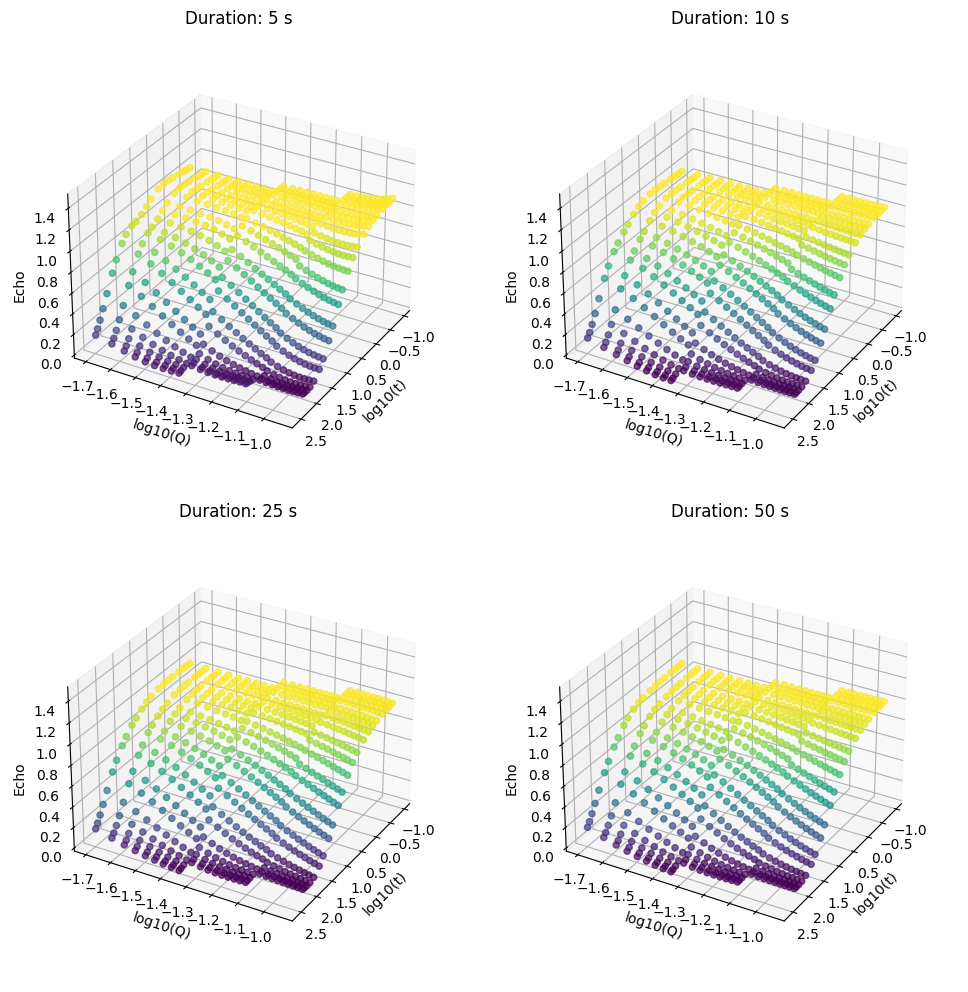

In [22]:
from scipy.optimize import curve_fit
fig = plt.figure(figsize=(10, 10))
for i, duration in enumerate(duration_list):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    axs.append(ax)
    
    sqt_GPR = sqt_GPR_list[i]
    sqt_exp = sqt_list[i]
    sqt_exp_err = sqt_err_list[i]
    # sqt_exp_err_lt 
    I_0 = I_0_list[i]
    
    ax.scatter(np.log10(t_obs), np.log10(Q_obs), sqt_GPR, c=sqt_GPR, alpha=0.7, vmax=1, vmin=0, cmap=cmap)
    # ax.scatter(np.log10(t_obs), np.log10(Q_obs), sqt_exp-sqt_exp_lt, c='k', alpha=0.7, vmax=0.5, vmin=-0.5, cmap="bwr")
    
    print(np.sqrt(np.mean(((sqt_GPR-sqt_exp_lt))**2)))

    ax.view_init(elev=30, azim=30)
    ax.set_zlim(0, 1.5)
    ax.set_xlabel('log10(t)')
    ax.set_ylabel('log10(Q)')
    ax.set_zlabel('Echo', rotation=90)
    ax.set_box_aspect(None, zoom=0.85)
    ax.set_title(f'Duration: {duration} s')
    
plt.tight_layout(pad=1.0)

In [23]:
I_0_list[0].shape

(27,)

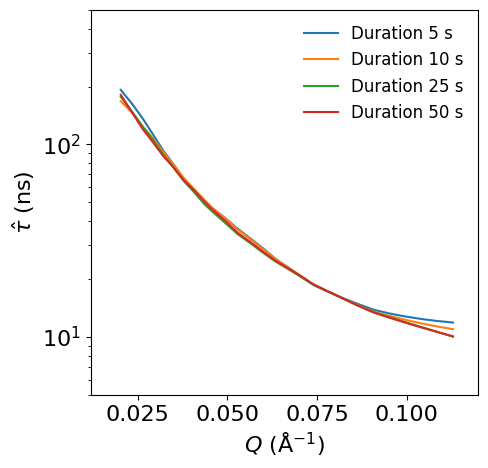

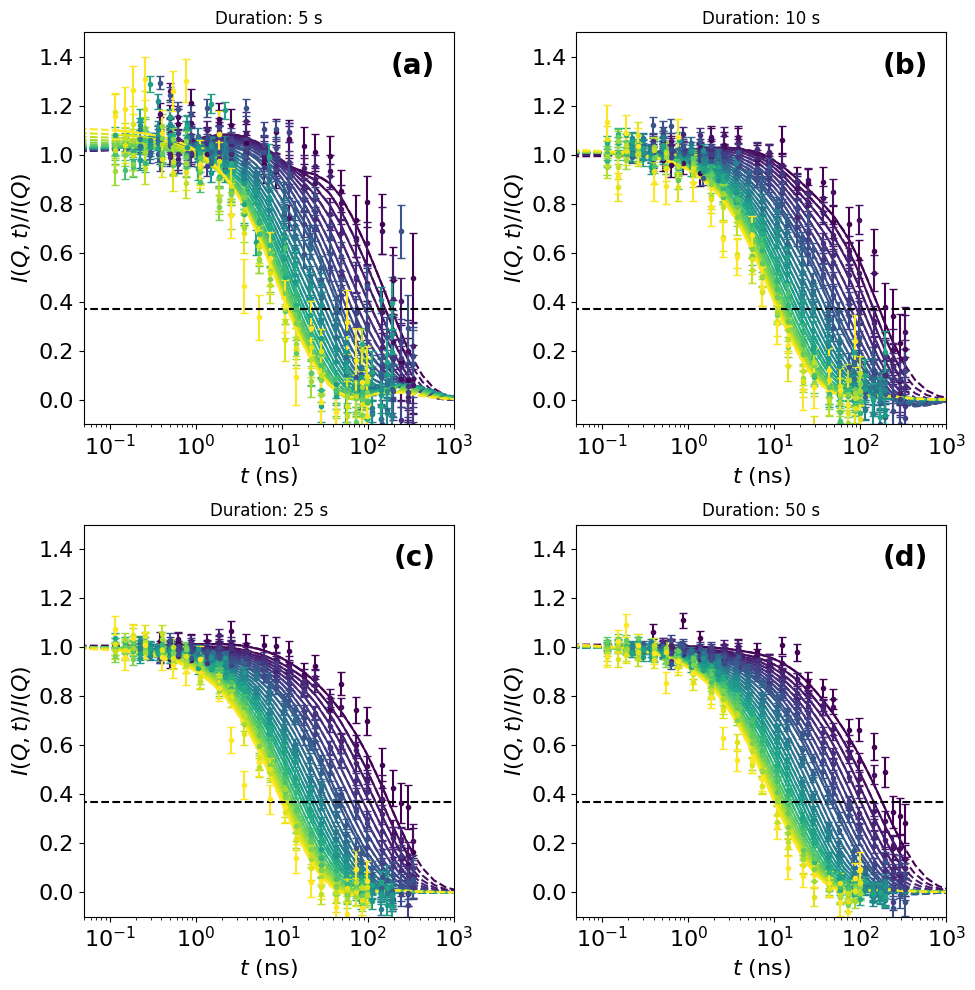

In [24]:
from scipy.interpolate import interp1d

# For each duration, make 2D curve plots for each unique Q
fig1 = plt.figure(figsize=(5, 5))
ax1 = fig1.add_subplot(111)

fig2, axs2 = plt.subplots(2, 2, figsize=(10, 10))  # Assuming len(duration_list) == 4
axs2 = axs2.flatten()
linestyles = ['-', '--', ':']
panel_labels = ['(a)', '(b)', '(c)', '(d)']

for i, duration in enumerate(duration_list):
    ax = axs2[i]
    
    t_reconstruct = np.logspace(-2, 4, 45)
    
    A_GPR = A_GPR_list[i]
    sqt_GPR_reconstruct = reconstruct_scattering_function(np.log(Q_eval), t_reconstruct, A_GPR, K_GPR, tau, lambda_, bg_mode=bg_mode)
    sqt_GPR_reconstruct = sqt_GPR_reconstruct[:len(sqt_exp),:]  # Ensure it matches the length of sqt_exp
    

    Q_vals = Q_obs
    t_vals = t_obs
    sqt_GPR_vals = sqt_GPR_list[i]
    exp_vals = sqt_list[i]  # or use sqt_exp_lt if needed
    exp_vals_err = sqt_err_list[i]
    exp_vals_lt = sqt_list[3]  # Take every third element
    exp_vals_err_lt = sqt_err_list[3]  # Take every third element
    
    I_0_vals = I_0_list[i]

    unique_Q = np.unique(Q_vals)
    
    import matplotlib.cm as cm
    import matplotlib.colors as mcolors

    norm = mcolors.Normalize(vmin=unique_Q.min(), vmax=unique_Q.max())
    cmap_q = cm.get_cmap('viridis')

    t_relaxation_list = []
    t_relaxation_err_list = []
    q_relaxation_list = []
    shift = 0.0  # Shift for each Q line in the plot
    for iq, q in enumerate(unique_Q):
        mask = Q_vals == q
        t_sorted_idx = np.argsort(t_vals[mask])
        t_sorted = t_vals[mask][t_sorted_idx]
        sqt_GPR_sorted = sqt_GPR_vals[mask][t_sorted_idx]
        exp_sorted = exp_vals[mask][t_sorted_idx]
        exp_sorted_lt = exp_vals_lt[mask][t_sorted_idx]
        exp_err_sorted = exp_vals_err[mask][t_sorted_idx]
        exp_err_sorted_lt = exp_vals_err_lt[mask][t_sorted_idx]
        
        sqt_GPR_reconstruct_sorted = sqt_GPR_reconstruct[mask,:][0,:]

        color = cmap_q(norm(q))
        ax.plot(t_sorted[1:], sqt_GPR_sorted[1:]+shift*iq, '-', label=f'GPR Q={q:.2f}', color=color)
        ax.plot(t_reconstruct, sqt_GPR_reconstruct_sorted+shift*iq, '--', label=f'GPR Reconstruct Q={q:.2f}', color=color)
        # ax.plot(t_sorted, exp_sorted, 'o', label=f'Exp Q={q:.2f}', alpha=0.6, color=color)
        # ax.plot(t_sorted, exp_sorted_lt, ':', label=f'Exp LT Q={q:.2f}', alpha=0.6, color=color)
        # ax.errorbar(t_sorted, exp_sorted_lt, yerr=exp_err_sorted_lt, fmt='.', alpha=0.6, color=color, capsize=3)
        ax.errorbar(t_sorted, exp_sorted+shift*iq, yerr=exp_err_sorted, fmt='.', alpha=1, color=color, capsize=3)
        
        # For multiple thresholds, e.g., exp(-1), exp(-2), exp(-3)
        thresholds = [np.exp(-n) for n in [1]]  # Adjust the range as needed
        t_relaxations = []
        t_relaxation_errs = []
        for th in thresholds:
            f_interp = interp1d(sqt_GPR_reconstruct_sorted, t_reconstruct, kind='linear', bounds_error=False, fill_value='extrapolate')
            t_relax = f_interp(th)
            rel_err = exp_err_sorted / np.abs(exp_sorted)
            t_relax_err = np.abs(t_relax) * np.mean(rel_err)
            t_relaxations.append(t_relax)
            t_relaxation_errs.append(t_relax_err)
        # Store results for the first threshold (exp(-1)) as before
        t_relaxation_list.append(t_relaxations)
        t_relaxation_err_list.append(t_relaxation_errs)
        q_relaxation_list.append(q)
        # Optionally, store or plot t_relaxations and t_relaxation_errs for other thresholds as needed
        

    for i_relax, t_relaxation in enumerate(np.array(t_relaxation_list).T):
        label = None
        if i_relax == 0:
            label=f'Duration {duration} s'
        ax1.plot(q_relaxation_list, t_relaxation, linestyles[i_relax], label=label, color=color_list[i])
    ax1.set_yscale('log')
    # ax1.set_xscale('log')
    ax1.set_xlabel(r'$Q$ ($\mathrm{\AA}^{-1}$)', fontsize=16)
    ax1.set_ylabel(r'$\hat{\tau}$ (ns)', fontsize=16)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    # ax1.set_xlim(1e-2, 2e-1)
    ax1.set_xlim(0.012, 0.12)
    ax1.set_ylim(5, 500)
    ax1.legend(fontsize=12, loc='upper right', frameon=False)

    ax.text(0.95, 0.95, panel_labels[i], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
    ax.set_xscale('log')
    # ax.set_scale('log')
    ax.set_xlabel(r'$t$ (ns)', fontsize=16)
    ax.set_ylabel('$I(Q,t)/I(Q)$', fontsize=16)
    ax.set_title(f'Duration: {duration} s')
    ax.set_ylim(-0.1, 1.5+len(unique_Q)*shift)
    ax.set_xlim(5e-2, 1e3)
    ax.tick_params(axis='both', which='major', labelsize=16)
    
    # ax.legend(ncol=2, fontsize=8, loc='upper right')

    ax.plot([1e-2, 1e4], [np.exp(-1), np.exp(-1)], 'k--')

plt.tight_layout()


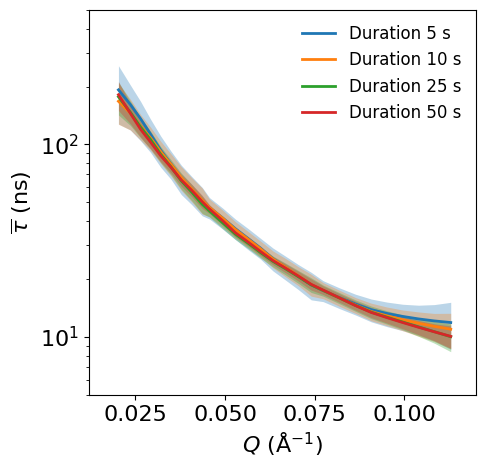

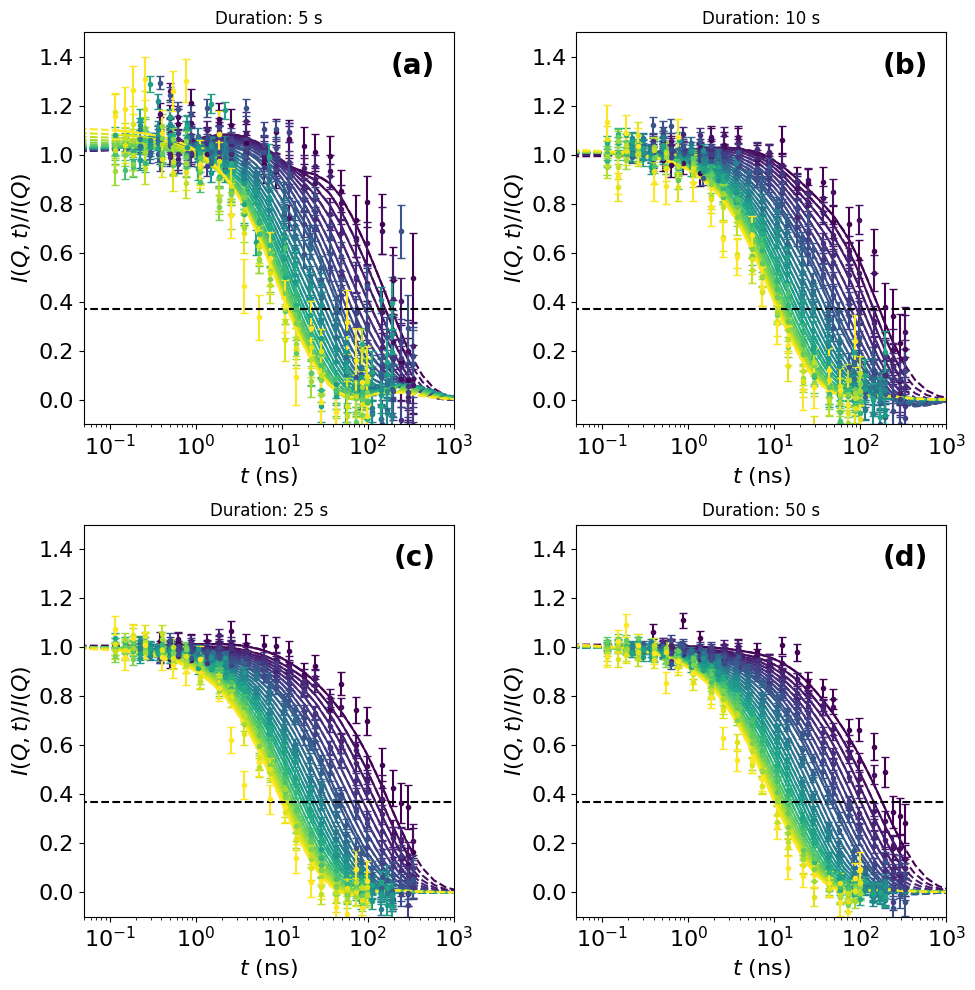

In [25]:
from scipy.interpolate import interp1d

# For each duration, make 2D curve plots for each unique Q
fig1 = plt.figure(figsize=(5, 5))
ax1 = fig1.add_subplot(111)

fig2, axs2 = plt.subplots(2, 2, figsize=(10, 10))  # Assuming len(duration_list) == 4
axs2 = axs2.flatten()
linestyles = ['-', '--', ':']
panel_labels = ['(a)', '(b)', '(c)', '(d)']

# (optional) fallback colors for ax1 if color_list not defined
try:
    _ = color_list
except NameError:
    color_list = ['tab:blue','tab:orange','tab:green','tab:red']

for i, duration in enumerate(duration_list):
    ax = axs2[i]

    t_reconstruct = np.logspace(-2, 4, 45)

    A_GPR = A_GPR_list[i]
    sqt_GPR_reconstruct = reconstruct_scattering_function(
        np.log(Q_eval), t_reconstruct, A_GPR, K_GPR, tau, lambda_, bg_mode=bg_mode
    )
    sqt_GPR_reconstruct = sqt_GPR_reconstruct[:len(sqt_exp), :]

    Q_vals = Q_obs
    t_vals = t_obs
    sqt_GPR_vals = sqt_GPR_list[i]
    exp_vals = sqt_list[i]
    exp_vals_err = sqt_err_list[i]

    unique_Q = np.unique(Q_vals)

    import matplotlib.cm as cm
    import matplotlib.colors as mcolors
    norm = mcolors.Normalize(vmin=unique_Q.min(), vmax=unique_Q.max())
    cmap_q = cm.get_cmap('viridis')

    # containers for fig1 (ax1)
    q_relaxation_list = []
    t_relaxation_list = []
    t_relaxation_err_list = []

    shift = 0.0
    for iq, q in enumerate(unique_Q):
        mask = (Q_vals == q)
        order = np.argsort(t_vals[mask])
        t_sorted = t_vals[mask][order]
        sqt_GPR_sorted = sqt_GPR_vals[mask][order]
        exp_sorted = exp_vals[mask][order]
        exp_err_sorted = exp_vals_err[mask][order]

        # reconstructed S(Q,t) on a dense grid for this Q
        S_rec = sqt_GPR_reconstruct[mask, :][0, :]          # shape (len(t_reconstruct),)
        color = cmap_q(norm(q))

        # --- panel (a–d) plotting (unchanged) ---
        ax.plot(t_sorted[1:], sqt_GPR_sorted[1:] + shift*iq, '-', color=color, label=f'GPR Q={q:.2f}')
        ax.plot(t_reconstruct, S_rec + shift*iq, '--', color=color, label=f'GPR Reconstruct Q={q:.2f}')
        ax.errorbar(t_sorted, exp_sorted + shift*iq, yerr=exp_err_sorted, fmt='.', alpha=1, color=color, capsize=3)

        # --- tau-hat and its uncertainty on ax1 ---
        # 1) locate \hat{tau} from S_rec(t) = e^{-1}
        f_t_of_S = interp1d(S_rec, t_reconstruct, kind='linear', bounds_error=False, fill_value='extrapolate')
        t_relax = float(f_t_of_S(np.exp(-1)))

        # 2) slope dS/dt at t = \hat{tau}
        dSdt_grid = np.gradient(S_rec, t_reconstruct)
        dSdt_at_tau = float(np.interp(t_relax, t_reconstruct, dSdt_grid))
        dSdt_at_tau = np.sign(dSdt_at_tau) * max(abs(dSdt_at_tau), 1e-12)  # guard against division by ~0

        # 3) observational sigma_S(t) interpolated to t = \hat{tau}
        sigmaS_of_t = interp1d(t_sorted, exp_err_sorted, kind='linear', bounds_error=False, fill_value='extrapolate')
        sigma_S_at_tau = float(sigmaS_of_t(t_relax))

        # 4) delta-method uncertainty
        sigma_tau = abs(sigma_S_at_tau / dSdt_at_tau)

        # store for fig1
        q_relaxation_list.append(q)
        t_relaxation_list.append(t_relax)
        t_relaxation_err_list.append(sigma_tau)

    # sort by Q before plotting on ax1
    order_q = np.argsort(q_relaxation_list)
    qs = np.asarray(q_relaxation_list)[order_q]
    taus = np.asarray(t_relaxation_list)[order_q]
    taus_err = np.asarray(t_relaxation_err_list)[order_q]

    # --- fig1: \hat{\tau}(Q) with shaded uncertainty band + dashed bounds ---
    # guard for log-scale (no nonpositive values)
    lower = np.maximum(taus - taus_err, 1e-12)
    upper = taus + taus_err
    base_color = color_list[i % len(color_list)]

    # central estimate (solid)
    ax1.plot(qs, taus, '-', lw=2, color=base_color, label=f'Duration {duration} s')

    # filled band
    ax1.fill_between(qs, lower, upper, color=base_color, alpha=0.3, linewidth=0)

    # # dashed bounds
    # ax1.plot(qs, lower, '--', lw=1.3, color=base_color)
    # ax1.plot(qs, upper, '--', lw=1.3, color=base_color)

    # (rest of your axis cosmetics below stay the same)
    ax.text(0.95, 0.95, panel_labels[i], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
    ax.set_xscale('log')
    ax.set_xlabel(r'$t$ (ns)', fontsize=16)
    ax.set_ylabel(r'$I(Q,t)/I(Q)$', fontsize=16)
    ax.set_title(f'Duration: {duration} s')
    ax.set_ylim(-0.1, 1.5 + len(unique_Q)*shift)
    ax.set_xlim(5e-2, 1e3)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.plot([1e-2, 1e4], [np.exp(-1), np.exp(-1)], 'k--')

# fig1 (ax1) cosmetics
ax1.set_yscale('log')
ax1.set_xlabel(r'$Q$ ($\mathrm{\AA}^{-1}$)', fontsize=16)
ax1.set_ylabel(r'$\overline{\tau}$ (ns)', fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.set_xlim(0.012, 0.12)
ax1.set_ylim(5, 500)
ax1.legend(fontsize=12, loc='upper right', frameon=False)

plt.tight_layout()


0.05291
0.086387
0.099556
0.11291
0.05291
0.086387
0.099556
0.11291


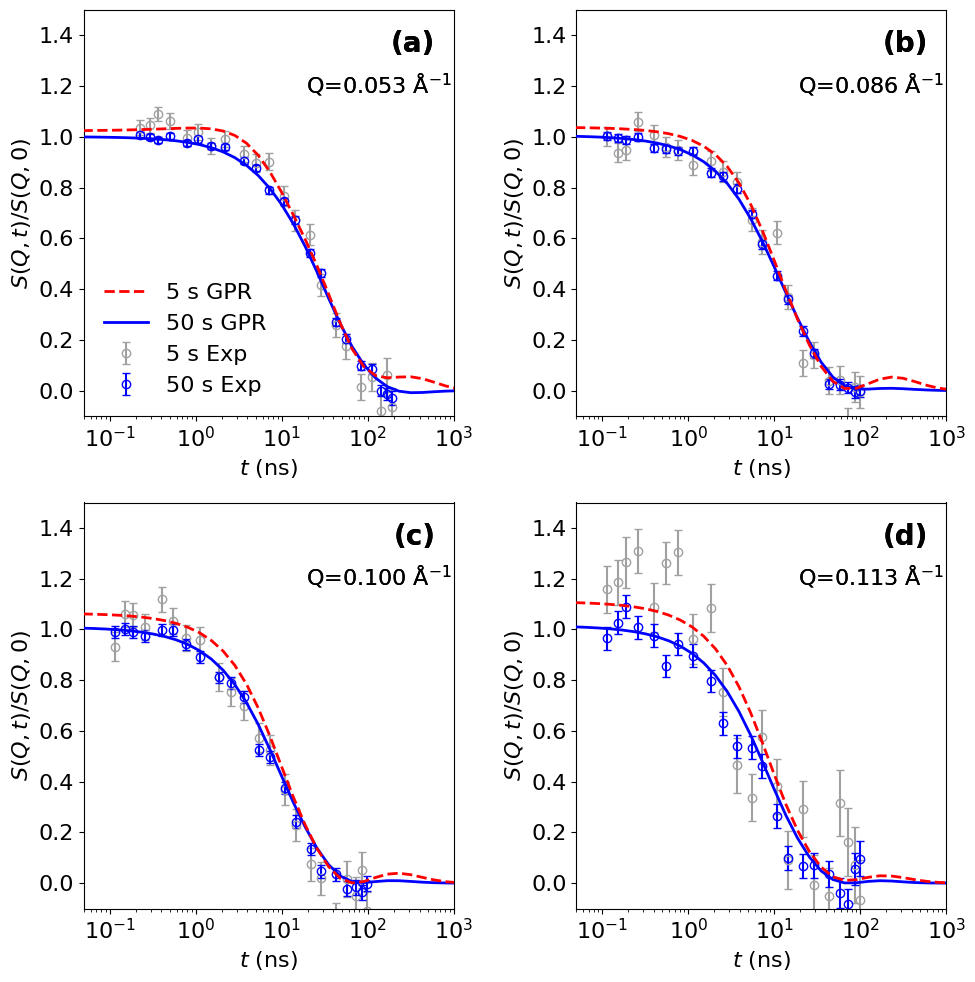

In [26]:


# For each duration, make 2D curve plots for each unique Q
# fig1 = plt.figure(figsize=(5, 5))
# ax1 = fig1.add_subplot(111)

fig2, axs2 = plt.subplots(2, 2, figsize=(10, 10))  # Assuming len(duration_list) == 4
axs2 = axs2.flatten()


linestyles = ['-', '--', ':']
panel_labels = ['(a)', '(b)', '(c)', '(d)']
index_list = [0, 3]  # Indices of durations to plot (e.g., 0 for 5s and 3 for 50s)

for i, duration in zip(index_list, duration_list[index_list]):
    # ax = ax1
    
    t_reconstruct = np.logspace(-2, 4, 45)
    
    A_GPR = A_GPR_list[i]
    sqt_GPR_reconstruct = reconstruct_scattering_function(np.log(Q_eval), t_reconstruct, A_GPR, K_GPR, tau, lambda_, bg_mode=bg_mode)
    sqt_GPR_reconstruct = sqt_GPR_reconstruct[:len(sqt_exp),:]  # Ensure it matches the length of sqt_exp
    

    Q_vals = Q_obs
    t_vals = t_obs
    sqt_GPR_vals = sqt_GPR_list[i]
    exp_vals = sqt_list[i]  # or use sqt_exp_lt if needed
    exp_vals_err = sqt_err_list[i]
    exp_vals_lt = sqt_list[3]  # Take every third element
    exp_vals_err_lt = sqt_err_list[3]  # Take every third element
    
    I_0_vals = I_0_list[i]

    unique_Q = np.unique(Q_vals)
    unique_Q = unique_Q[[11, 20, 23, 26]]
    
    import matplotlib.cm as cm
    import matplotlib.colors as mcolors

    norm = mcolors.Normalize(vmin=unique_Q.min(), vmax=unique_Q.max())
    cmap_q = cm.get_cmap('viridis')

    t_relaxation_list = []
    t_relaxation_err_list = []
    q_relaxation_list = []
    shift = 0.0  # Shift for each Q line in the plot
    for iq, q in enumerate(unique_Q):
        ax = axs2[iq]
        print(q)
        mask = Q_vals == q
        t_sorted_idx = np.argsort(t_vals[mask])
        t_sorted = t_vals[mask][t_sorted_idx]
        sqt_GPR_sorted = sqt_GPR_vals[mask][t_sorted_idx]
        exp_sorted = exp_vals[mask][t_sorted_idx]
        exp_sorted_lt = exp_vals_lt[mask][t_sorted_idx]
        exp_err_sorted = exp_vals_err[mask][t_sorted_idx]
        exp_err_sorted_lt = exp_vals_err_lt[mask][t_sorted_idx]
        
        sqt_GPR_reconstruct_sorted = sqt_GPR_reconstruct[mask,:][0,:]

        # color = cmap_q(norm(q))
        if i==0:
            color_data = '#A0A0A0'
            color_GP = 'r'
            fillstyle = 'none'
            linestyle = '--'
            label_data = f'5 s Exp'
            label_line = f'5 s GPR'
            zorder = 20
            
        else:
            color_data = 'b'
            color_GP = 'b'
            fillstyle = 'none'
            linestyle = '-'
            label_data = f'50 s Exp'
            label_line = f'50 s GPR'
            zorder = 5
  
        # ax.plot(t_sorted[1:], sqt_GPR_sorted[1:]+shift*iq, linestyles[i], label=f'GPR Q={q:.2f}', color=color)
        # if i==0:
        ax.plot(t_reconstruct, sqt_GPR_reconstruct_sorted+shift*iq, linestyle, label=label_line, color=color_GP, linewidth=2, zorder=zorder)
        # ax.plot(t_sorted, exp_sorted, 'o', label=f'Exp Q={q:.2f}', alpha=0.6, color=color)
        # ax.plot(t_sorted, exp_sorted_lt, ':', label=f'Exp LT Q={q:.2f}', alpha=0.6, color=color)
        # ax.errorbar(t_sorted, exp_sorted_lt, yerr=exp_err_sorted_lt, fmt='.', alpha=0.6, color=color, capsize=3)
        ax.errorbar(t_sorted, exp_sorted+shift*iq, yerr=exp_err_sorted, fmt='o', alpha=1, color=color_data, capsize=3, fillstyle=fillstyle, label=label_data)
        
        ax.text(0.95, 0.95, panel_labels[iq], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
        ax.text(0.6, 0.85, f'Q={q:.3f} $\mathrm{{\AA}}^{{-1}}$', transform=ax.transAxes, fontsize=16, va='top', ha='left', color='k')
        ax.set_xscale('log')
        # ax.set_scale('log')
        ax.set_xlabel(r'$t$ (ns)', fontsize=16)
        ax.set_ylabel('$S(Q,t)/S(Q,0)$', fontsize=16)
        # ax.set_title(f'Duration: {duration} s')
        ax.set_ylim(-0.1, 1.5+len(unique_Q)*shift)
        ax.set_xlim(5e-2, 1e3)
        ax.tick_params(axis='both', which='major', labelsize=16)

        if iq==0:
            ax.legend(ncol=1, fontsize=16, loc='lower left', frameon=False)

        # ax.plot([1e-2, 1e4], [np.exp(-1), np.exp(-1)], 'k--')
    
    

plt.tight_layout()


In [27]:
# load D22 data
path = "../binning/data/G5_res_1_8C/"
filename = path + "287906_d07_c07.dat"
data_D22 = np.loadtxt(filename, skiprows=52)

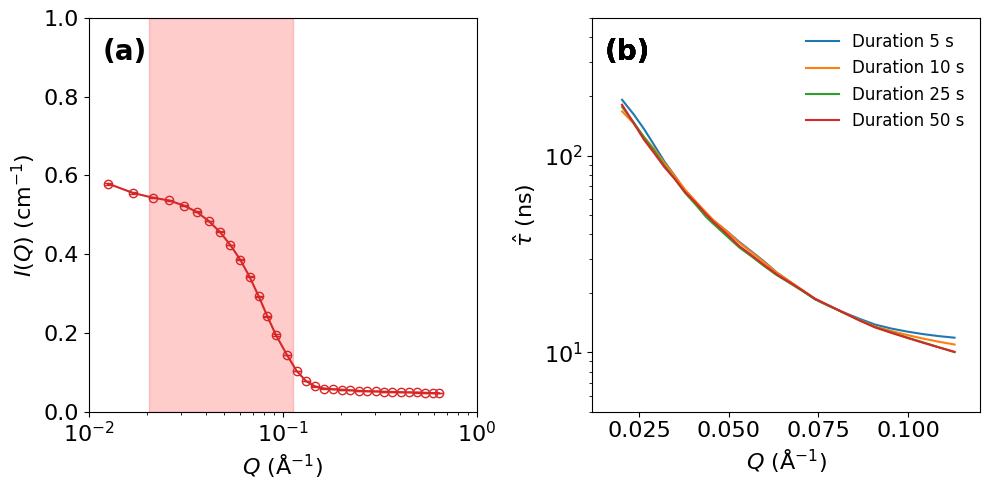

In [28]:
from scipy.interpolate import interp1d

# For each duration, make 2D curve plots for each unique Q
fig1 = plt.figure(figsize=(10, 5))
ax1 = fig1.add_subplot(122)
ax2 = fig1.add_subplot(121)

linestyles = ['-', '--', ':']
panel_labels = ['(a)', '(b)', '(c)', '(d)']

for i, duration in enumerate(duration_list):

    t_reconstruct = np.logspace(-2, 4, 45)
    
    A_GPR = A_GPR_list[i]
    sqt_GPR_reconstruct = reconstruct_scattering_function(np.log(Q_eval), t_reconstruct, A_GPR, K_GPR, tau, lambda_, bg_mode=bg_mode)
    sqt_GPR_reconstruct = sqt_GPR_reconstruct[:len(sqt_exp),:]  # Ensure it matches the length of sqt_exp
    

    Q_vals = Q_obs
    t_vals = t_obs
    sqt_GPR_vals = sqt_GPR_list[i]
    exp_vals = sqt_list[i]  # or use sqt_exp_lt if needed
    exp_vals_err = sqt_err_list[i]
    exp_vals_lt = sqt_list[3]  # Take every third element
    exp_vals_err_lt = sqt_err_list[3]  # Take every third element
    
    I_0_vals = I_0_list[i]
    I_0_err_vals = I_0_err_list[i]

    unique_Q = np.unique(Q_vals)
    
    import matplotlib.cm as cm
    import matplotlib.colors as mcolors

    norm = mcolors.Normalize(vmin=unique_Q.min(), vmax=unique_Q.max())
    cmap_q = cm.get_cmap('viridis')

    t_relaxation_list = []
    t_relaxation_err_list = []
    q_relaxation_list = []
    shift = 0.0  # Shift for each Q line in the plot
    for iq, q in enumerate(unique_Q):
        mask = Q_vals == q
        t_sorted_idx = np.argsort(t_vals[mask])
        t_sorted = t_vals[mask][t_sorted_idx]
        sqt_GPR_sorted = sqt_GPR_vals[mask][t_sorted_idx]
        exp_sorted = exp_vals[mask][t_sorted_idx]
        exp_sorted_lt = exp_vals_lt[mask][t_sorted_idx]
        exp_err_sorted = exp_vals_err[mask][t_sorted_idx]
        exp_err_sorted_lt = exp_vals_err_lt[mask][t_sorted_idx]
        
        sqt_GPR_reconstruct_sorted = sqt_GPR_reconstruct[mask,:][0,:]

        color = cmap_q(norm(q))
        ax.plot(t_sorted[1:], sqt_GPR_sorted[1:]+shift*iq, '-', label=f'GPR Q={q:.2f}', color=color)
        ax.plot(t_reconstruct, sqt_GPR_reconstruct_sorted+shift*iq, '--', label=f'GPR Reconstruct Q={q:.2f}', color=color)
        # ax.plot(t_sorted, exp_sorted, 'o', label=f'Exp Q={q:.2f}', alpha=0.6, color=color)
        # ax.plot(t_sorted, exp_sorted_lt, ':', label=f'Exp LT Q={q:.2f}', alpha=0.6, color=color)
        # ax.errorbar(t_sorted, exp_sorted_lt, yerr=exp_err_sorted_lt, fmt='.', alpha=0.6, color=color, capsize=3)
        ax.errorbar(t_sorted, exp_sorted+shift*iq, yerr=exp_err_sorted, fmt='.', alpha=1, color=color, capsize=3)
        
        # For multiple thresholds, e.g., exp(-1), exp(-2), exp(-3)
        thresholds = [np.exp(-n) for n in [1]]  # Adjust the range as needed
        t_relaxations = []
        t_relaxation_errs = []
        for th in thresholds:
            f_interp = interp1d(sqt_GPR_reconstruct_sorted, t_reconstruct, kind='linear', bounds_error=False, fill_value='extrapolate')
            t_relax = f_interp(th)
            rel_err = exp_err_sorted / np.abs(exp_sorted)
            t_relax_err = np.abs(t_relax) * np.mean(rel_err)
            t_relaxations.append(t_relax)
            t_relaxation_errs.append(t_relax_err)
        # Store results for the first threshold (exp(-1)) as before
        t_relaxation_list.append(t_relaxations)
        t_relaxation_err_list.append(t_relaxation_errs)
        q_relaxation_list.append(q)
        # Optionally, store or plot t_relaxations and t_relaxation_errs for other thresholds as needed
        

    for i_relax, t_relaxation in enumerate(np.array(t_relaxation_list).T):
        label = None
        if i_relax == 0:
            label=f'Duration {duration} s'
        ax1.plot(q_relaxation_list, t_relaxation, linestyles[i_relax], label=label, color=color_list[i])
    ax1.set_yscale('log')
    # ax1.set_xscale('log')
    ax1.set_xlabel(r'$Q$ ($\mathrm{\AA}^{-1}$)', fontsize=16)
    ax1.set_ylabel(r'$\hat{\tau}$ (ns)', fontsize=16)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    # ax1.set_xlim(1e-2, 2e-1)
    ax1.set_xlim(0.012, 0.12)
    ax1.set_ylim(5, 500)
    ax1.legend(fontsize=12, loc='upper right', frameon=False)
    ax1.text(0.15, 0.95, '(b)', transform=ax1.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

ax2.errorbar(data_D22[1:, 0], data_D22[1:, 1], yerr=data_D22[1:, 2], fmt='o-', color=color_list[i], capsize=3, fillstyle='none', label='D22 data')
ax2.fill_between(unique_Q, np.ones(len(unique_Q))*0,
                 np.ones(len(unique_Q))*1e0,
                 color="r", alpha=0.2)
# ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel(r'$Q$ ($\mathrm{\AA}^{-1}$)', fontsize=16)
ax2.set_ylabel(r'$I(Q)$ (cm$^{-1}$)', fontsize=16)
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.set_xlim(0.01, 1)
ax2.set_ylim(0, 1)
ax2.text(0.15, 0.95, '(a)', transform=ax2.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

plt.tight_layout()


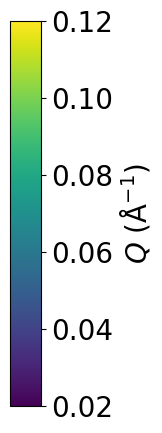

In [29]:
# Create a vertical colorbar according to the time list in viridis colormap
fig, ax = plt.subplots(figsize=(0.4, 5))
norm = plt.Normalize(vmin=0.02, vmax=0.12)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=ax)
cbar.set_label(r'$Q$ ($\mathrm{\AA}^{-1}$)', fontsize=20)
cbar.ax.tick_params(labelsize=20)

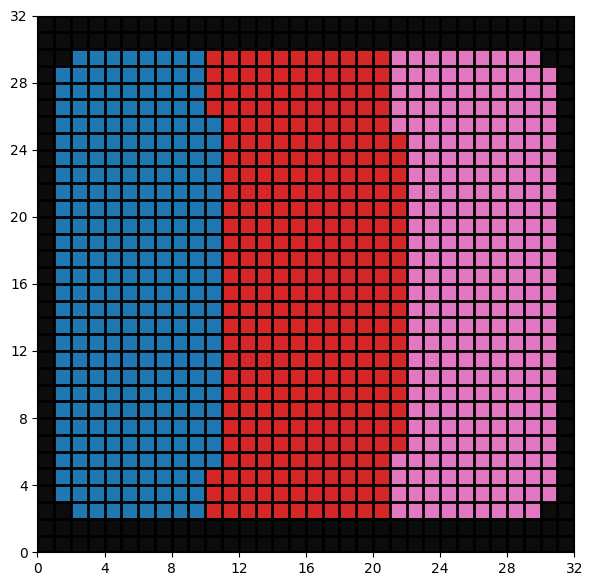

In [30]:
# Grid parameters
grid_size = 32
grid = np.ones((grid_size, grid_size, 3))  # RGB image, initialized to white

# Define physical coordinates: assume 1 unit per pixel, origin at bottom-left
x = np.arange(grid_size)
y = np.arange(grid_size)
xx, yy = np.meshgrid(x, y)

# Define center in physical coordinates
center_x, center_y = -64, 16  # Given in physical units

# Compute Euclidean distances from center
distances = np.sqrt((xx - center_x)**2 + (yy - center_y)**2)

# Normalize distances and discretize into groups
norm_dist = (distances - distances.min()) / (distances.max() - distances.min())
n_group = 4
norm_dist_discretized = np.clip((norm_dist * (n_group-1)).astype(np.uint8), 0, n_group - 1)

# Map discrete groups to colors
cmap_tab = plt.cm.tab10
group_colors = cmap_tab(np.linspace(0, 1, n_group))
colored_grid = group_colors[norm_dist_discretized][:, :, :3]

# Mark invalid edge and corner pixels in grey
# Mark invalid edge and corner pixels in grey
grey = [0.05, 0.05, 0.05]
colored_grid[:2, :, :] = grey       # Top two rows
colored_grid[-2:, :, :] = grey      # Bottom two rows
colored_grid[:, :1, :] = grey       # Left two columns
colored_grid[:, -1:, :] = grey      # Right two columns
colored_grid[2, 1, :] = grey
colored_grid[2, -2, :] = grey
colored_grid[-3, 1, :] = grey
colored_grid[-3, -2, :] = grey

# Plot the grid with tile boundaries
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(colored_grid, extent=[0, grid_size, 0, grid_size])

# Draw tile boundaries
for i in range(grid_size + 1):
    ax.axhline(i, color='black', linewidth=2)
    ax.axvline(i, color='black', linewidth=2)

ax.set_xticks(np.arange(0, grid_size+1, 4))
ax.set_yticks(np.arange(0, grid_size+1, 4))
ax.set_aspect('equal')
ax.set_xlim(0, grid_size)
ax.set_ylim(0, grid_size)
plt.tight_layout()
plt.show()


In [19]:
t_relaxation_list

[[array(183.0612468)],
 [array(145.79091689)],
 [array(120.17838588)],
 [array(102.90839386)],
 [array(87.40327436)],
 [array(76.17404872)],
 [array(65.42572523)],
 [array(57.854372)],
 [array(50.44362452)],
 [array(46.24049805)],
 [array(40.08644462)],
 [array(34.76045362)],
 [array(31.14920075)],
 [array(27.81098368)],
 [array(24.90673233)],
 [array(22.74859144)],
 [array(20.73517865)],
 [array(18.75231788)],
 [array(17.50917847)],
 [array(15.93065807)],
 [array(14.54500245)],
 [array(13.40381698)],
 [array(12.60948684)],
 [array(11.88815897)],
 [array(11.24113564)],
 [array(10.65454904)],
 [array(10.09391117)]]